# Tutorial 3: Running Quantization-Aware Training (QAT) on Bert

In this tutorial, we'll build on top of Tutorial 2 by taking the Bert model fine tuned for sequence classification and running Mase's quantization pass. First, we'll run simple Post-Training Quantization (PTQ) and see how much accuracy drops. Then, we'll run some further training iterations of the quantized model (i.e. QAT) and see whether the accuracy of the trained quantized model approaches the accuracy of the original (full-precision) model.

In [1]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

## Importing the model

If you are starting from scratch, you can create a MaseGraph for Bert by running the following cell.

In [14]:
from transformers import AutoModelForSequenceClassification

from chop import MaseGraph
import chop.passes as passes

model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
model.config.problem_type = "single_label_classification"

mg = MaseGraph(
    model,
    hf_input_names=[
        "input_ids",
        "attention_mask",
        "labels",
    ],
)

mg, _ = passes.init_metadata_analysis_pass(mg)
mg, _ = passes.add_common_metadata_analysis_pass(mg)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.


tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[ 101, 9932, 2089, 2202, 2058, 1996, 2088, 2028, 2154,  102],
        [ 101, 2023, 2003, 2339, 2017, 2323, 4553, 4748, 4877,  102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],


        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]]])
tensor([[[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       

If you have previously ran the tutorial on LoRA Finetuning, run the following cell to import the fine tuned checkpoint.

In [2]:
from pathlib import Path
from transformers import AutoModelForSequenceClassification

from chop import MaseGraph
import chop.passes as passes

mg = MaseGraph.from_checkpoint(f"{Path.home()}/tutorial_2_lora")

/vol/bitbucket/hv122/adls_group_14/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.


## Post-Training Quantization (PTQ)

Here, we simply quantize the model and evaluate the effect in its accuracy. First, let's evaluate the model accuracy before quantization (if you're coming from Tutorial 2, this should be the same as the post-LoRA evaluation accuracy). As seen in Tutorial 2, we can use the `get_tokenized_dataset` and `get_trainer` utilities to generate a HuggingFace `Trainer` instance for training and evaluation.

In [3]:
from chop.tools import get_tokenized_dataset, get_trainer

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)

# Evaluate accuracy
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.83436


To run the quantization pass, we pass a quantization configuration dictionary as argument. This defines the quantization mode, numerical format and precision for each operator in the graph. We'll run the quantization in "by type" mode, meaning nodes are quantized according to their `mase_op`. Other modes include by name and by regex name. We'll quantize all activations, weights and biases in the model to fixed-point with the same precision. This may be sub-optimal, but works as an example. In future tutorials, we'll see how to run the `search` flow in `Mase` to find optimal quantization configurations to minimize accuracy loss.

In [4]:
import chop.passes as passes

quantization_config = {
    "by": "type",
    "default": {
        "config": {
            "name": None,
        }
    },
    "linear": {
        "config": {
            "name": "integer",
            # data
            "data_in_width": 8,
            "data_in_frac_width": 4,
            # weight
            "weight_width": 8,
            "weight_frac_width": 4,
            # bias
            "bias_width": 8,
            "bias_frac_width": 4,
        }
    },
}

mg, _ = passes.quantize_transform_pass(
    mg,
    pass_args=quantization_config,
)

Let's evaluate the immediate effect of quantization on the model accuracy.

In [5]:
trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.81572


We can save the current checkpoint for future reference (optional).

In [6]:
from pathlib import Path

mg.export(f"{Path.home()}/tutorial_3_ptq")

INFO     Exporting MaseGraph to /homes/hv122/tutorial_3_ptq.pt, /homes/hv122/tutorial_3_ptq.mz
INFO     Exporting GraphModule to /homes/hv122/tutorial_3_ptq.pt
INFO     Saving full model format
INFO     Exporting MaseMetadata to /homes/hv122/tutorial_3_ptq.mz


## Quantization-Aware Training (QAT)

You should have seen in the last section that quantization can lead to a significant drop in accuracy. Next, we'll run QAT to evaluate whether this performance gap can be reduced. To run QAT in Mase, all you need to do is include the model back in your training loop after running the quantization pass.

In [7]:
# Evaluate accuracy
trainer.train()
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

Step,Training Loss
500,0.410900
1000,0.407400
1500,0.412500
2000,0.395000
2500,0.394100
3000,0.388800


Evaluation accuracy: 0.83672


We can see the accuracy of the quantized model can match (or sometimes exceed) the full precision model, with a much lower memory requirement to store the weights. Finally, save the final checkpoint for future tutorials.

In [8]:
from pathlib import Path

mg.export(f"{Path.home()}/tutorial_3_qat")

INFO     Exporting MaseGraph to /homes/hv122/tutorial_3_qat.pt, /homes/hv122/tutorial_3_qat.mz
INFO     Exporting GraphModule to /homes/hv122/tutorial_3_qat.pt
INFO     Saving full model format
INFO     Exporting MaseMetadata to /homes/hv122/tutorial_3_qat.mz


Bit-width Task

Check the format the data is in - does it require more fractional or integer bits for precise representation?


In [9]:
import torch.nn as nn

print(f"{'Layer Name':<40} | {'Shape':<20} | {'Mean':<10} | {'Std':<10} | {'Range'}")
print("-" * 105)

for name, module in mg.model.named_modules():
    if isinstance(module, nn.Linear):
        weights = module.weight.data
        
        w_min = weights.min().item()
        w_max = weights.max().item()
        w_mean = weights.mean().item()
        w_std = weights.std().item()
        
        print(f"{name:<40} | {str(list(weights.shape)):<20} | {w_mean:<10.4f} | {w_std:<10.4f} | [{w_min:.4f}, {w_max:.4f}]")

Layer Name                               | Shape                | Mean       | Std        | Range
---------------------------------------------------------------------------------------------------------
bert.encoder.layer.0.attention.self.query | [128, 128]           | -0.0004    | 0.0725     | [-0.3396, 0.3785]
bert.encoder.layer.0.attention.self.key  | [128, 128]           | 0.0004     | 0.0710     | [-0.3119, 0.3087]
bert.encoder.layer.0.attention.self.value | [128, 128]           | 0.0001     | 0.1006     | [-0.5005, 0.5147]
bert.encoder.layer.0.attention.output.dense | [128, 128]           | 0.0000     | 0.1031     | [-0.6122, 0.4754]
bert.encoder.layer.0.intermediate.dense  | [512, 128]           | -0.0012    | 0.0743     | [-0.6432, 0.6168]
bert.encoder.layer.0.output.dense        | [128, 512]           | -0.0002    | 0.0618     | [-1.2637, 1.1070]
bert.encoder.layer.1.attention.self.query | [128, 128]           | -0.0008    | 0.1032     | [-0.4905, 0.3709]
bert.encoder.layer.1

It seems that we can limit the integer width quite strictly, we'll explore a limited area of integer width, and then explore the rest of space left to us in the 32 bit-width with fractional bits.

In [10]:
import pandas as pd
from pandas import DataFrame

result_log = []
first_run = {}

# Evaluate accuracy before PTQ
pre_ptq_eval_results = trainer.evaluate()
first_run["Finetuned Accuracy"] = pre_ptq_eval_results['eval_accuracy']
print(f"Finetuned accuracy: {pre_ptq_eval_results['eval_accuracy']}")
result_log.append(first_run)

Finetuned accuracy: 0.83672


In [ ]:
def execute_whole_int_loop():
  for width in range(5, 12):
    mg = MaseGraph.from_checkpoint(f"{Path.home()}/tutorial_2_lora")
    current_run = {
                "Total Width": width,
                "Fractional Width": 4, 
                "Integer Bits": width - 4
            }
    dataset, tokenizer = get_tokenized_dataset(
        dataset=dataset_name,
        checkpoint=tokenizer_checkpoint,
        return_tokenizer=True,
    )

    trainer = get_trainer(
        model=mg.model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
    )

    import chop.passes as passes

    quantization_config = {
        "by": "type",
        "default": {
            "config": {
                "name": None,
            }
        },
        "linear": {
            "config": {
                "name": "integer",
                # data
                "data_in_width": width,
                "data_in_frac_width": 4,
                # weight
                "weight_width": width,
                "weight_frac_width": 4,
                # bias
                "bias_width": width,
                "bias_frac_width": 4,
            }
        },
    }

    mg, _ = passes.quantize_transform_pass(
        mg,
        pass_args=quantization_config,
    )

    trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
  )
    post_ptq_result = trainer.evaluate()
    current_run["Post-PTQ Accuracy"] = post_ptq_result['eval_accuracy']
    print(f"PTQ accuracy: {post_ptq_result['eval_accuracy']}")

    trainer.train()
    post_qat_result = trainer.evaluate()
    current_run["Post-QAT Accuracy"] = post_qat_result['eval_accuracy']
    print(f"QAT accuracy: {post_qat_result['eval_accuracy']}")

    result_log.append(current_run)

In [ ]:
execute_whole_int_loop()

WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.71908


Step,Training Loss
500,0.505000
1000,0.455300
1500,0.455600
2000,0.430700
2500,0.423000


In [14]:
int_sweep_df = DataFrame(result_log)
print(int_sweep_df)

   Finetuned Accuracy  Total Width  Fractional Width  Integer Bits  \
0             0.83672          NaN               NaN           NaN   
1                 NaN          5.0               4.0           1.0   
2                 NaN          6.0               4.0           2.0   
3                 NaN          7.0               4.0           3.0   
4                 NaN          8.0               4.0           4.0   
5                 NaN          9.0               4.0           5.0   
6                 NaN         10.0               4.0           6.0   
7                 NaN         11.0               4.0           7.0   

   Post-PTQ Accuracy  Post-QAT Accuracy  
0                NaN                NaN  
1            0.71908            0.81716  
2            0.76848            0.83436  
3            0.78336            0.83592  
4            0.81572            0.83672  
5            0.81768            0.83676  
6            0.81768            0.83652  
7            0.81768            0

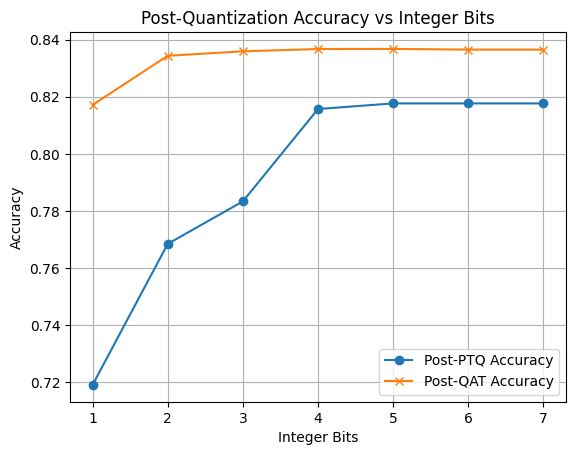

In [36]:
import matplotlib.pyplot as plt

plt.plot(int_sweep_df["Integer Bits"], int_sweep_df["Post-PTQ Accuracy"], marker="o", label="Post-PTQ Accuracy")
plt.plot(int_sweep_df["Integer Bits"], int_sweep_df["Post-QAT Accuracy"], marker="x", label="Post-QAT Accuracy")
plt.title("Post-Quantization Accuracy vs Integer Bits")
plt.xlabel("Integer Bits")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.savefig("tut3_integer_bits.png")

In [ ]:
frac_result_log = []
frac_result_log.append(first_run)

def execute_whole_frac_loop():
  for width in range(3, 28):
    mg = MaseGraph.from_checkpoint(f"{Path.home()}/tutorial_2_lora")
    current_run = {
                "Total Width": width + 5,
                "Fractional Width": width, 
                "Integer Bits": 5
            }
    dataset, tokenizer = get_tokenized_dataset(
        dataset=dataset_name,
        checkpoint=tokenizer_checkpoint,
        return_tokenizer=True,
    )

    trainer = get_trainer(
        model=mg.model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
    )

    import chop.passes as passes

    quantization_config = {
        "by": "type",
        "default": {
            "config": {
                "name": None,
            }
        },
        "linear": {
            "config": {
                "name": "integer",
                # data
                "data_in_width": width + 5,
                "data_in_frac_width": width,
                # weight
                "weight_width": width + 5,
                "weight_frac_width": width,
                # bias
                "bias_width": width + 5,
                "bias_frac_width": width,
            }
        },
    }

    mg, _ = passes.quantize_transform_pass(
        mg,
        pass_args=quantization_config,
    )

    trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
  )
    post_ptq_result = trainer.evaluate()
    current_run["Post-PTQ Accuracy"] = post_ptq_result['eval_accuracy']
    print(f"PTQ accuracy: {post_ptq_result['eval_accuracy']}")

    trainer.train()
    post_qat_result = trainer.evaluate()
    current_run["Post-QAT Accuracy"] = post_qat_result['eval_accuracy']
    print(f"QAT accuracy: {post_qat_result['eval_accuracy']}")

    frac_result_log.append(current_run)

In [28]:
execute_whole_frac_loop()

WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.5


Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.5


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.5


Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.5


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.69176


Step,Training Loss
500,0.567600
1000,0.470900
1500,0.444000
2000,0.415400
2500,0.424900
3000,0.411700


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.82964


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.81768


Step,Training Loss
500,0.414000
1000,0.407900
1500,0.414400
2000,0.392000
2500,0.392000
3000,0.388500


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.83676


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.82956


Step,Training Loss
500,0.405300
1000,0.400700
1500,0.410700
2000,0.385800
2500,0.388400
3000,0.388300


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.83908


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.83172


Step,Training Loss
500,0.405300
1000,0.400200
1500,0.408600
2000,0.385300
2500,0.384200
3000,0.385100


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.83888


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.83092


Step,Training Loss
500,0.404400
1000,0.400100
1500,0.406200
2000,0.384900
2500,0.384100
3000,0.385400


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.83904


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.83404


Step,Training Loss
500,0.404400
1000,0.399500
1500,0.407500
2000,0.384500
2500,0.384200
3000,0.385700


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.83876


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.8346


Step,Training Loss
500,0.404700
1000,0.399300
1500,0.407200
2000,0.384300
2500,0.383500
3000,0.385500


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.8388


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.83336


Step,Training Loss
500,0.404100
1000,0.399300
1500,0.407100
2000,0.384500
2500,0.383600
3000,0.385700


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.83908


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.83472


Step,Training Loss
500,0.404100
1000,0.399600
1500,0.407100
2000,0.384500
2500,0.383700
3000,0.385700


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.83896


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.83436


Step,Training Loss
500,0.404200
1000,0.399500
1500,0.407000
2000,0.384500
2500,0.383700
3000,0.385600


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.83896


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.834


Step,Training Loss
500,0.404300
1000,0.399500
1500,0.407000
2000,0.384500
2500,0.383700
3000,0.385600


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.83888


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.83432


Step,Training Loss
500,0.404200
1000,0.399400
1500,0.407000
2000,0.384500
2500,0.383700
3000,0.385600


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.83888


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.83432


Step,Training Loss
500,0.404200
1000,0.399500
1500,0.407000
2000,0.384500
2500,0.383700
3000,0.385600


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.83888


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.83436


Step,Training Loss
500,0.404200
1000,0.399500
1500,0.407000
2000,0.384500
2500,0.383700
3000,0.385600


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.83888


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.83436


Step,Training Loss
500,0.404200
1000,0.399500
1500,0.407000
2000,0.384500
2500,0.383700
3000,0.385600


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.83888


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.83436


Step,Training Loss
500,0.404200
1000,0.399500
1500,0.407000
2000,0.384500
2500,0.383700
3000,0.385600


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.83888


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.83436


Step,Training Loss
500,0.404200
1000,0.399500
1500,0.407000
2000,0.384500
2500,0.383700
3000,0.385600


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.83888


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.83436


Step,Training Loss
500,0.404200
1000,0.399500
1500,0.407000
2000,0.384500
2500,0.383700
3000,0.385600


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.83888


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.83436


Step,Training Loss
500,0.404200
1000,0.399500
1500,0.407000
2000,0.384500
2500,0.383700
3000,0.385600


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.83888


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.83436


Step,Training Loss
500,0.404200
1000,0.399500
1500,0.407000
2000,0.384500
2500,0.383700
3000,0.385600


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.83888


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.83436


Step,Training Loss
500,0.404200
1000,0.399500
1500,0.407000
2000,0.384500
2500,0.383700
3000,0.385600


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.83888


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.83436


Step,Training Loss
500,0.404200
1000,0.399500
1500,0.407000
2000,0.384500
2500,0.383700
3000,0.385600


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.83888


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.83436


Step,Training Loss
500,0.404200
1000,0.399500
1500,0.407000
2000,0.384500
2500,0.383700
3000,0.385600


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.83888


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.83436


Step,Training Loss
500,0.404200
1000,0.399500
1500,0.407000
2000,0.384500
2500,0.383700
3000,0.385600


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.
INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


QAT accuracy: 0.83888


Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at /homes/hv122/.cache/huggingface/datasets/imdb/plain_text/0.0.0/e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Mon Jan 26 16:13:14 2026).
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/vol/bitbucket/hv122/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


PTQ accuracy: 0.83436


Step,Training Loss
500,0.404200
1000,0.399500
1500,0.407000
2000,0.384500
2500,0.383700
3000,0.385600


QAT accuracy: 0.83888


In [30]:
frac_df = DataFrame(frac_result_log)
print(frac_df)

    Finetuned Accuracy  Total Width  Fractional Width  Integer Bits  \
0              0.83672          NaN               NaN           NaN   
1                  NaN          6.0               1.0           5.0   
2                  NaN          6.0               1.0           5.0   
3                  NaN          7.0               2.0           5.0   
4                  NaN          8.0               3.0           5.0   
5                  NaN          9.0               4.0           5.0   
6                  NaN         10.0               5.0           5.0   
7                  NaN         11.0               6.0           5.0   
8                  NaN         12.0               7.0           5.0   
9                  NaN         13.0               8.0           5.0   
10                 NaN         14.0               9.0           5.0   
11                 NaN         15.0              10.0           5.0   
12                 NaN         16.0              11.0           5.0   
13    

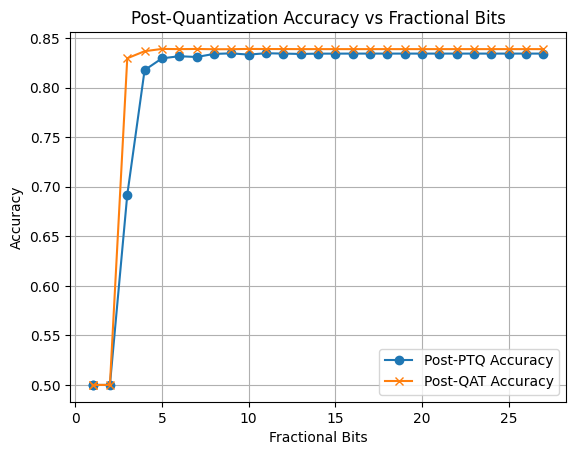

In [37]:
plt.plot(frac_df["Fractional Width"], frac_df["Post-PTQ Accuracy"], marker="o", label="Post-PTQ Accuracy")
plt.plot(frac_df["Fractional Width"], frac_df["Post-QAT Accuracy"], marker="x", label="Post-QAT Accuracy")
plt.title("Post-Quantization Accuracy vs Fractional Bits")
plt.xlabel("Fractional Bits")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.savefig("tut3_fractional_bits.png")